## Fine-tuning Transfer Learning

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

Fine-tuning is a type of transfer learning where you:

Start with a pre-trained model (e.g., ResNet, BERT, GPT).

Adjust its parameters (weights) by continuing training on your smaller, task-specific dataset.

In this section you can optionally:

1. Freeze some layers (e.g., early layers that detect generic features like edges/word syntax).

2. Train the entire model end-to-end with a lower learning rate.

OR

3. Update only the later layers (more task-specific features like organs in X-rays or sentiment in reviews), which we have already implemented in the previous notebook.



Let us first import TensorFlow and che its version:

In [108]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


And then check if we are using either GPU or CPU?

In [109]:
!nvidia-smi

Wed Oct  8 14:43:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |    2170MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Also, we have to download the module `helper_functions.py module`:

In [110]:
import os

# GitHub raw URL of the module
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py"
filename = "helper_functions.py"

# Download only if not already present
if not os.path.exists(filename):
    print(f"Downloading {filename} from GitHub...")
    !wget -q -O {filename} {url}
    print(f"Downloaded {filename} to the current directory.")
else:
    print(f"{filename} already exists in the current directory.")

helper_functions.py already exists in the current directory.


In [111]:
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

Now download data as we did in the previous notebook.

In [112]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

# OR alternatively

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

--2025-10-08 14:43:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.207, 74.125.139.207, 108.177.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   186MB/s    in 0.9s    

2025-10-08 14:43:18 (186 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



Typically the file structure should be like:

```
10_food_classes_10_percent/          <- parent directory
├── train                            <- training images
│   ├── pizza
│   │   │   1647351.jpg
│   │   │   1647352.jpg
│   │   │   ...
│   └── steak
│       │   1648001.jpg
│       │   1648050.jpg
│       │   ...
│
└── test                             <- testing images
    ├── pizza
    │   │   1001116.jpg
    │   │   1507019.jpg
    │   │   ...      
    └── steak
        │   100274.jpg
        │   1653815.jpg
        │   ...
```

In [113]:
import tensorflow as tf

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Calling a TensorFlow utility above (`tf.keras.preprocessing.image_dataset_from_directory`), we simply and quickly build a dataset of images from a folder structure.

If you want to see an example batch of data, you could use the `take()` method.

In [114]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.06219383e+02 6.62908096e+01 2.12193871e+01]
   [7.51071396e+01 3.32499962e+01 3.87755060e+00]
   [1.16658173e+02 7.14387817e+01 3.65663338e+01]
   ...
   [1.67112518e+02 1.04035988e+02 3.62553253e+01]
   [1.90953964e+02 1.25122314e+02 5.69539146e+01]
   [1.64065765e+02 9.42238770e+01 2.55300655e+01]]

  [[9.89030609e+01 5.01887741e+01 1.08877516e+01]
   [1.10719406e+02 5.80765457e+01 2.50051174e+01]
   [1.78627548e+02 1.24897964e+02 8.72551041e+01]
   ...
   [1.63550919e+02 1.01295837e+02 2.42958775e+01]
   [1.33311172e+02 7.31632233e+01 3.51021385e+00]
   [1.40056335e+02 7.96991959e+01 1.68165779e+01]]

  [[1.63908157e+02 1.08122444e+02 5.85561142e+01]
   [1.44178574e+02 8.55204086e+01 4.35612183e+01]
   [1.26862244e+02 6.40306091e+01 2.10561218e+01]
   ...
   [1.68484192e+02 1.03963814e+02 1.37751322e+01]
   [1.38800934e+02 8.26733932e+01 8.88779831e+00]
   [1.36740219e+02 8.51739273e+01 2.83985405e+01]]

  ...

  [[2.50785736e+02 2.38290848e+02 1.57852020e+02]
   [2

Now we are ready to launch our first model (the baseline)...

We’ll use the `tf.keras.applications` module, which provides a collection of pre-trained computer vision models (trained on ImageNet), along with the Keras Functional API to build our model. But what are the right steps one should take...?

Model 0: Building a transfer learning model using the Keras Functional API

In order to create a baseline in our case, you can do as follows:

1. Instantiate a pre-trained base model object by choosing a target model such as `EfficientNetV2B0` and setting the `include_top` parameter to `False`.
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model (data shape expected by the model)
4. Normalize the inputs to our model if it requires (e.g., `EfficientNetV2B0`).
5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors)
7. Create an output activation layer via `tf.keras.layers.Dense()`
8. Merge the inputs and outputs layer into a new model using `tf.keras.Model()`
9. Compile the model, passing the loss function and optimizer
10. Fit the model for as many epochs as necessary.

In [115]:
# Create base model
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)

# Freeze base model layers
base_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to the base model
x = base_model(inputs)

print(f"Shape after base_model: {x.shape}")

# Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# Create the activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Merge inputs and outputs into a new model via Model()
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.15 * len(test_data_10_percent)),
                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                               experiment_name="model_0_baseline")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: training_logs/model_0_baseline/20251008-144321
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 792ms/step - accuracy: 0.3013 - loss: 2.0993 - val_accuracy: 0.7415 - val_loss: 1.3292
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7371 - loss: 1.1968 - val_accuracy: 0.8239 - val_loss: 0.9124
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7860 - loss: 0.8971 - val_accuracy: 0.8182 - val_loss: 0.7493
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8522 - loss: 0.6856 - val_accuracy: 0.8295 - val_loss: 0.6935
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.8521 - loss: 0.6040 - val_accuracy: 0.8551 - val_loss: 0.5530


What we did exactly is:

We took our custom dataset, fed it into a pre-trained model (`EfficientNetV2B0`), let it identify meaningful patterns, and then added our own output layer to match the number of classes we needed.

Keras Functional API is used instead of using the Sequential one to create the model.

### Model Inspection

Before proceeding with model inspection, it is important to note that the model is currently in the process of being fine-tuned, and as such, its weights and configurations may not fully reflect the final intended setup. At this stage, we will focus on examining the model’s architecture and layer structure to better understand its components, verify the expected configuration, and ensure that the fine-tuning process is applied to the correct parameters.


In [116]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer_23
1 rescaling_17
2 normalization_17
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_

In [117]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_17        │ (None, None,      │          0 │ input_layer_23[0… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_17    │ (None, None,      │          0 │ rescaling_17[0][… │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization_17… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

What about he summary of the model we just constructed?

In [118]:
model_0.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

**NOTE!** A pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of.

As you can see, the only trainable parameters in the model are those in the output layer.



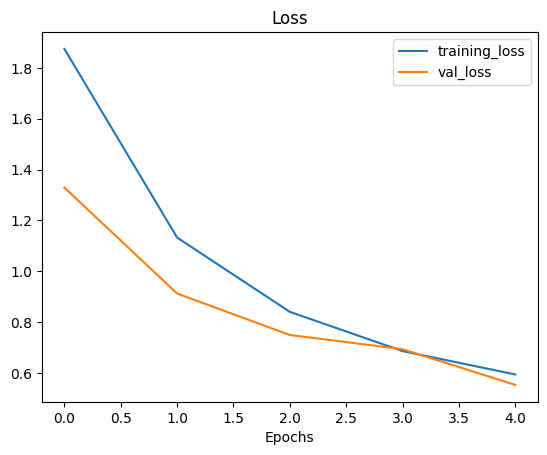

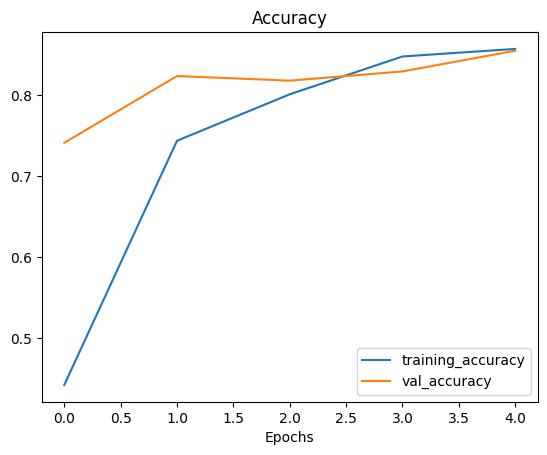

In [119]:
plot_loss_curves(history_0)

### Extract a Feature Vector

Now let us see what a single feature vector of a trained model might look like...



In [120]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


**Why use `GlobalAveragePooling2D()`?**

- Prevents overfitting (fewer parameters vs. Flatten + Dense).
- Reduces computation.
- Works well for classification tasks by keeping only the presence of a feature, not its exact location.

The operation above can also be replicated by `tf.reduce_mean()`, specifying the right axis.

In [121]:
# the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### Transfer Learning Experiments

We’ve already observed impressive results from transfer learning using just 10% of the training data. But what happens if we shrink that to only 1%?

Can transfer learning still deliver strong performance when using 100x less data than the CNN models we trained from scratch?

To find out, we’ll run the following experiments:

**Model 1**: Apply feature extraction with transfer learning on 1% of the training data, using data augmentation.

**Model 2**: Apply feature extraction with transfer learning on 10% of the training data, with data augmentation, and save a checkpoint.

**Model 3**: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.

**Model 4**: Fine-tune the Model 2 checkpoint on the full training dataset with data augmentation.

Although the models will train on different subsets of the data, all results will be evaluated against the same test set to ensure fair comparison.

All experiments will use `EfficientNetV2B0` from the `tf.keras.applications.efficientnet_v2 module`.

We will also use `create_tensorboard_callback()` function to log all of the model training logs to make sure we're keeping track of our experiments.

Then let's first download the data for **experiment 1**:

In [122]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2025-10-08 14:44:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 108.177.12.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   184MB/s    in 0.7s    

2025-10-08 14:44:14 (184 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [123]:
# Investigate the directories and number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

**Oh no!** Looks like we've only got seven images of each class, this should be a bit of a challenge for our model.

In [124]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE
                                                                           )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Transfer Learning on 1% of the Training Data, Using Data Augmentation

To apply augmentation this time, we’ll integrate it directly into the model by using the tf.keras.layers module and setting up a dedicated data augmentation layer.

Incorporating a data augmentation layer into the model provides several advantages:

- Image preprocessing (augmentation) is executed on the GPU instead of the CPU, resulting in significantly faster performance.

  - While images benefit from GPU-based preprocessing, text and structured data are generally better handled on the CPU.

- Image augmentation occurs only during training, allowing the entire model to be exported and used elsewhere without issue. This also ensures that others can retrain the model with the same augmentation strategy if needed.

**ADDITIONAL NOTE!**

Keras gives you several ways to create models depending on how much control or flexibility you need.

1. Sequential API
  - The simplest way to build a model in Keras.
  - You just stack layers one after another.
  - Best for linear flow models (input → hidden layers → output), no branches or multiple inputs/outputs.

  ✅ Easy, readable, quick prototyping. \
  ❌ Limited — can’t handle complex architectures (e.g., models with multiple inputs, outputs, or shared layers).

2. Functional API

- More flexible.
- You explicitly define inputs and outputs and can build models with non-linear flows: multiple inputs, multiple outputs, shared layers, residual connections, etc.

✅ Great for complex architectures. \
✅ Very explicit — you see the full computational graph. \
❌ A bit more verbose than Sequential

3. Model Subclassing (Custom Class)

- You define your model as a Python class by subclassing tf.keras.Model.
- Gives maximum flexibility — you can write your own forward pass (call() method), conditional logic, loops, etc.

✅ Ideal for research, custom architectures, dynamic computation. \
❌ More code, less beginner-friendly.

4. Model with `Sequential + Functional` Hybrid \
Sometimes you mix — e.g., use Sequential blocks inside a Functional API model for modularity.

We can apply data augmentation directly in our model by building a **Keras Sequential** model that contains only preprocessing layers. This Sequential model can then be integrated into a larger **Functional** model.

In [129]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")

Now, in order to tets it out, we can pass random images through it and see the result.

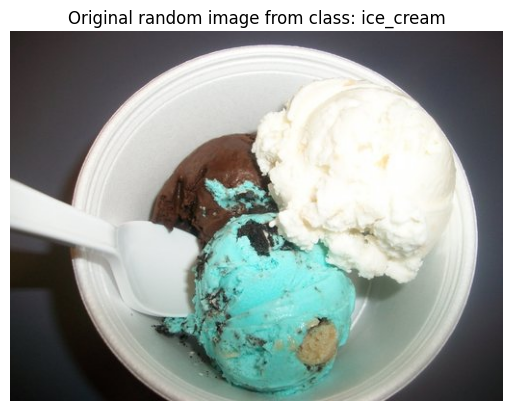

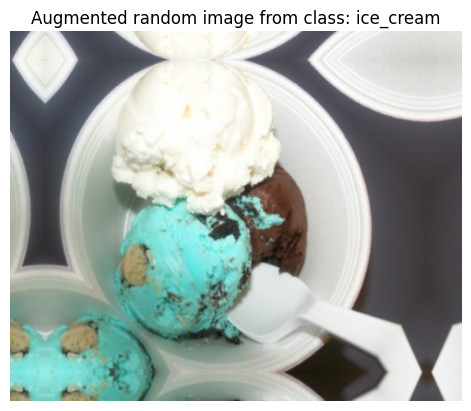

In [126]:
# Pick and display a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Apply augmentation to the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Just in case you were wondering what changes after dimension expansion is applied:

In [127]:
print(f"Image shape before expansion: {img.shape}")
print(f"Image shae after expansion: {tf.expand_dims(img, axis=0).shape}")

Image shape before expansion: (384, 512, 3)
Image shae after expansion: (1, 384, 512, 3)


### MODEL 1: Feature extraction TL on 1% of the data + data augmentation

In [130]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input Layer
inputs = layers.Input(shape=input_shape, name="input_layer")
print(inputs.shape)
# Data Augmentation (Pre-processing)
x = data_augmentation(inputs)

# Pass the input into the base model
x = base_model(x, training=False)
# Apply average pooling
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# Add a dense layer to collect output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create model
model_1 = keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                               experiment_name="model_1_feature_extraction_1_percent_data_augmentation")])

(None, 224, 224, 3)
Saving TensorBoard log files to: training_logs/model_1_feature_extraction_1_percent_data_augmentation/20251008-144457
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.0891 - loss: 2.4359 - val_accuracy: 0.1003 - val_loss: 2.3616
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step - accuracy: 0.2016 - loss: 2.2138 - val_accuracy: 0.1793 - val_loss: 2.2404
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 945ms/step - accuracy: 0.3088 - loss: 2.0443 - val_accuracy: 0.2188 - val_loss: 2.1503
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 844ms/step - accuracy: 0.3712 - loss: 1.9806 - val_accuracy: 0.2763 - val_loss: 2.0664
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 844ms/step - accuracy: 0.5501 - loss: 1.7735 - val_accuracy: 0.2895 - val_loss: 1.9867


In [131]:
model_1.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [132]:
# Evaluate the model on test data
results_1 = model_1.evaluate(test_data)
results_1

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.3060 - loss: 1.9799


[1.9845390319824219, 0.31839999556541443]

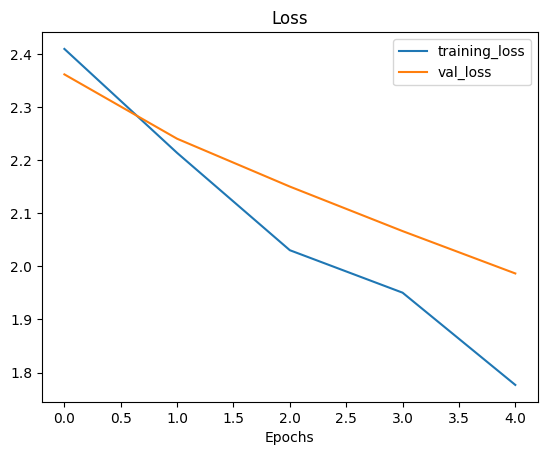

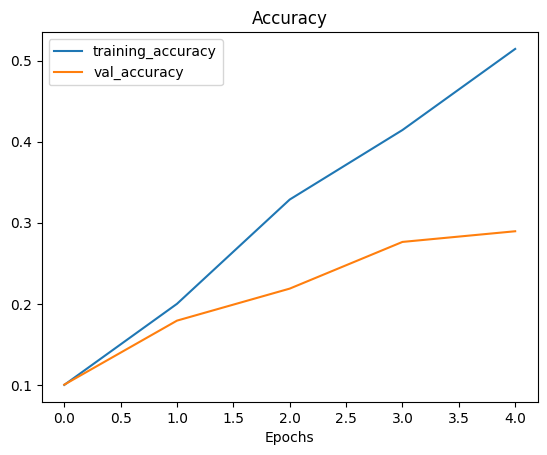

In [133]:
# Now let us plot it and see the performance graph
plot_loss_curves(history_1)

### MODEL 2: Feature extraction TL on 10% of the data + data augmentation

Practically speaking, as we’ve discussed, aim to minimize the time between experiments. Run many small tests with limited data and fewer training iterations until you find something promising, then scale it up.

On that note, let’s expand our previous 1% training data augmentation experiment to 10%. That phrasing might sound odd, but you get the idea.

We’ll follow the same steps as before—the only change is using 10% of the training data instead of 1%.

In [134]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [135]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Not necessary to create test data since it already exists
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [136]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.Resizing(224, 224),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

In [137]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
# Augment the training images
x = data_augmentation(inputs)
# Pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

There is  also a nicer way to create an instance of your model. Below you can find out how...

In [138]:
# Define a function which returns the model
def create_model(input_shape: tuple[int, int, int]=(224, 224, 3),
                 output_shape: int = 10,
                 learning_rate: float = 0.001,
                 training=False) -> tf.keras.Model:
  """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
  """

  # Create base model
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
  base_model.trainable = training

  # Setup model input and outputs with data augmentation built-in
  inputs = layers.Input(shape=input_shape, name="input_layer")
  x = data_augmentation(inputs)
  x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
  x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
  model = tf.keras.Model(inputs, outputs)

  # Compile model
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["accuracy"])

  return model


model_2 = create_model()

To save the model at specific intervals (e.g., after each epoch or when validation accuracy improves), one can also create a **ModelCheckpoint** callback so they can:

- Resume training later
- Restore the best model and not just the last one
- Avoid manual model saving

The ModelCheckpoint callback in TensorFlow (Keras) is a built-in utility that allows you to automatically save your model or its weights during training — typically after each epoch or whenever a certain performance metric improves.

It’s part of TensorFlow’s tf.keras.callbacks module and helps prevent losing progress or overfitting by keeping the best-performing model checkpoints.

In [139]:
# Setup path for your checkpoints
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

It is time to fit our model given the 10% data at hand for now.

In [140]:
# Fit the model
# It will save checkpoints every epoch
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20251008-145058
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.2155 - loss: 2.1712
Epoch 1: val_loss improved from inf to 1.49411, saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 500ms/step - accuracy: 0.2196 - loss: 2.1644 - val_accuracy: 0.6250 - val_loss: 1.4941
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6379 - loss: 1.4853
Epoch 2: val_loss improved from 1.49411 to 1.07359, saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 333ms/step - accuracy: 0.6389 - loss: 1.4823 - val_accuracy: 0.7632 - val_loss: 1.0736
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7126 - loss: 1.1834
Epoch 3: val_loss improved from 1.07359 to 0.87925, saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - ac

In [141]:
# Evaluate on the test data
results_2 = model_2.evaluate(test_data)
results_2

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8154 - loss: 0.6974


[0.692193329334259, 0.8180000185966492]

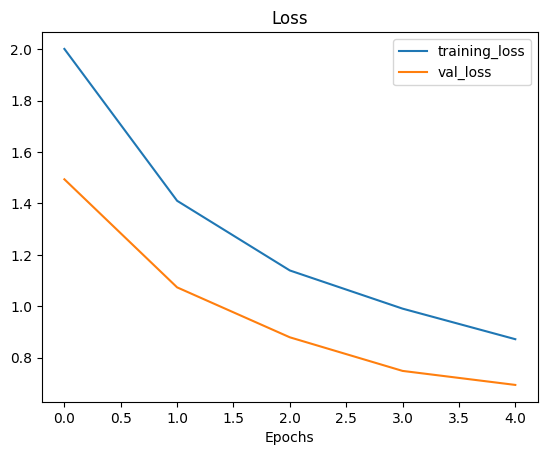

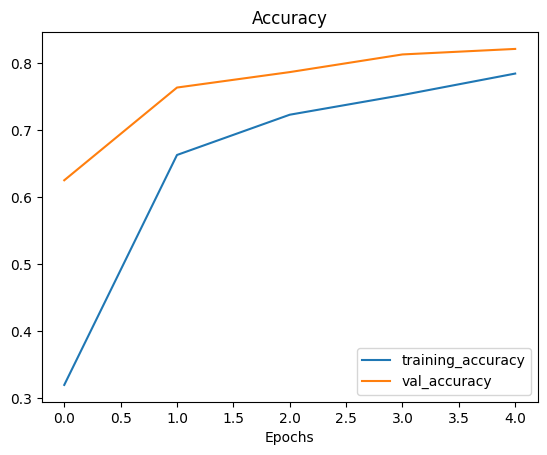

In [142]:
# Plot loss curves
plot_loss_curves(history_2)

To load saved model weights you can use the the `load_weights()` method, passing only the path where it has been saved.

In [143]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8183 - loss: 0.6967


In [144]:
results_2 == loaded_weights

True

Since the above cell did not output `False`, the results are valid. But you should also remember that the values produced are not exactly the same considering them in full precision (they are stored with a certain degree of precision). You can also gain assurance via the code snippet below:

In [145]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_2), np.array(loaded_weights))

array([ True,  True])

In [146]:
# Check the difference between the two results (if present, small values are expected)
print(np.array(results_2) - np.array(loaded_weights))

[0. 0.]


### Model 3: Fine-tuning the latest model on 10% of the data (Partially Fine-Tuning Base Model)

We have previously seen and learned how Fine-tuning and Feature Extraction TL are implemented. For the next experiment, we would like to take the stored model (from the last experiment) and unfreeze some of its base model's layers (closest to the top) in order to fine-tune it running the model for a few more epochs. Note that base model basically refers to `efficientnetv2-b0` which has already got several layers of parameters.

**Additional Note**: Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data.

In [147]:
# Layers in loaded model
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [148]:
# Extract useful information of each layer
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <InputLayer name=input_layer, built=True> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <Sequential name=data_augmentation, built=True> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <Functional name=efficientnetv2-b0, built=True> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <GlobalAveragePooling2D name=global_average_pooling_layer, built=True> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <Dense name=output_layer, built=True> | Trainable? True


In [149]:
# Model summary
model_2.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

From the number of trainable values, it can be easily understood that only the dense output layer is set as trainable

Also you can access the the layers of the base model `efficientnetv2-b0` via `model_2.layers[2]`.

In [150]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [151]:
# Trainable layers of efficientnetv2-b0
print(len(model_2_base_model.trainable_variables))

0


What if we go further and try to see how the layers are structured in depth...
In order to do so, we can first set all the layers as trainable (`True`) and then freeze (set to `False`) all the layers except for the last 10.

In [152]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_30 False
1 rescaling_21 False
2 normalization_21 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a

In [153]:
# Make all the layers in base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any similar modifications)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [154]:
print(len(model_2.trainable_variables))

12


In [155]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_2_fine_tune = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_2.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20251008-145218
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 492ms/step - accuracy: 0.7633 - loss: 1.0042 - val_accuracy: 0.8207 - val_loss: 0.7444
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.7464 - loss: 0.9419 - val_accuracy: 0.8207 - val_loss: 0.6929
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.7830 - loss: 0.8448 - val_accuracy: 0.8421 - val_loss: 0.6084
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.7815 - loss: 0.8062 - val_accuracy: 0.8388 - val_loss: 0.6044
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.8201 - loss: 0.7403 - val_accuracy: 0.8536 - val_loss: 0.5486
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 326ms/step - accuracy: 0.8140 - loss: 0.7346 - val_accuracy: 0.8355 - val_loss: 0.5442


In [156]:
# Evaluate the model on the test data
results_2_fine_tune = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8402 - loss: 0.5443


### Compare Results (Feature Extraction TL vs. Feature Extraction TL + Partial Tuning)

As we have already discussed, in **Feature Extraction TL**, the pretrained model’s parameters are frozen and only the final classifier is trained and in **Feature Extraction TL + Partial Fine-tuning**, selected layers of the base model are fine-tuned along with the classifier. The comparison focuses on evaluating how partial tuning affects model performance, generalization, and training efficiency relative to using fixed feature representations.

In [157]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3199999928474426, 0.6626666784286499, 0.7226666808128357, 0.7519999742507935, 0.7839999794960022, 0.7506666779518127, 0.7559999823570251, 0.7773333191871643, 0.7986666560173035, 0.8213333487510681, 0.8199999928474426]


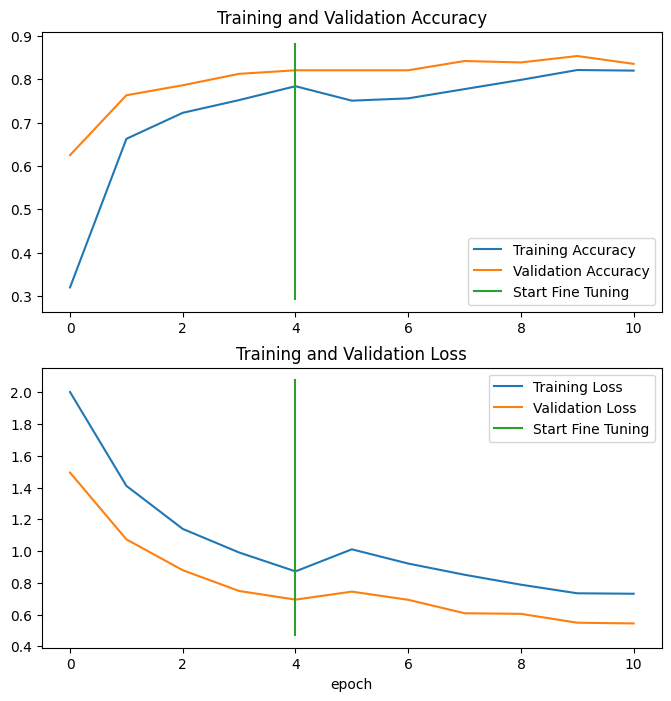

In [158]:
compare_historys(original_history=history_2,
                 new_history=history_2_fine_tune,
                 initial_epochs=5)

### Model 4: Fine-tuning the same model on all of the data (Partially Fine-Tuning Base Model)

In [159]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2025-10-08 14:53:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 172.217.203.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  38.8MB/s    in 5.5s    

2025-10-08 14:53:27 (90.4 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [160]:
# Walk through the categories we are going to work on
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [161]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


**NOTE**: The test dataset is the same we've been using for our previous experiments.

As it is now, our `model_2` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction. Below are the same values as `results_2`.

In [162]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8517 - loss: 0.5273


[0.5423915386199951, 0.8411999940872192]

In [163]:
results_2_fine_tune

[0.5423914790153503, 0.8411999940872192]

To ensure a clean experimental setup, we’ll create a fresh instance of **model_2** using the `create_base_model()` function.

Specifically, we’re comparing:

- **Experiment 3 (previous):** `model_2` with 10 layers fine-tuned for 5 additional epochs on 10% of the dataset.  
- **Experiment 4 (current):** `model_2` with layers fine-tuned for 5 additional epochs on 100% of the dataset.



In [165]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

In [166]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [167]:
model_2.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [168]:
print(len(model_2.trainable_variables))

2


In [169]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.8329 - loss: 0.6750


[0.6921931505203247, 0.8180000185966492]

In [170]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [171]:
# Unfreeze the top 10 layers
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [172]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_31 False
1 rescaling_22 False
2 normalization_22 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a

In [173]:
# Recompile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [175]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_2.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20251008-150300
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 68s 236ms/step - accuracy: 0.7181 - loss: 1.0245 - val_accuracy: 0.8849 - val_loss: 0.4249
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 48s 205ms/step - accuracy: 0.7719 - loss: 0.7402 - val_accuracy: 0.8997 - val_loss: 0.3390
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 77s 182ms/step - accuracy: 0.8033 - loss: 0.6559 - val_accuracy: 0.9062 - val_loss: 0.2861
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.8175 - loss: 0.5946 - val_accuracy: 0.9178 - val_loss: 0.2724
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - accuracy: 0.8252 - loss: 0.5611 - val_accuracy: 0.9178 - val_loss: 0.2512
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 159ms/step - accuracy: 0.8349 - loss: 0.5258 - val_accuracy: 0.9227 - val_loss: 0.2431


In [176]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9272 - loss: 0.2435


[0.2589554190635681, 0.9187999963760376]

In [178]:
results_2_fine_tune

[0.5423914790153503, 0.8411999940872192]

Wo0w! Seems like the results are improved!!

5
11
[0.3199999928474426, 0.6626666784286499, 0.7226666808128357, 0.7519999742507935, 0.7839999794960022, 0.7398666739463806, 0.7796000242233276, 0.8041333556175232, 0.8202666640281677, 0.8306666612625122, 0.8361333608627319]


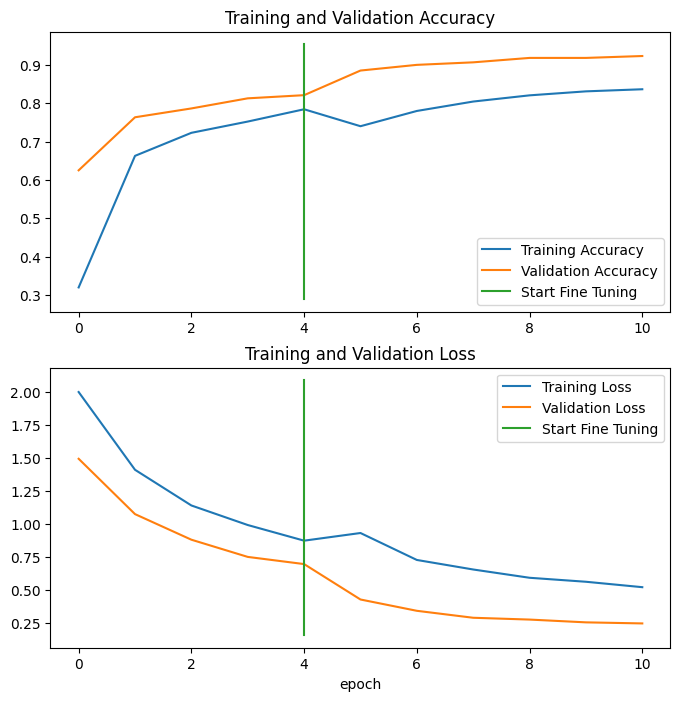

In [180]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_2,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

As you may have already noticed, the curves have also improved which proves once again the better performance of the model with greater amount of data.